In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [29]:
pip list

Package                   Version
------------------------- ----------------
alembic                   1.12.0
anyio                     4.0.0
apturl                    0.5.2
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.0
async-lru                 2.0.4
attrs                     23.1.0
Babel                     2.13.0
backcall                  0.2.0
beautifulsoup4            4.12.2
bleach                    6.1.0
blinker                   1.6.3
Brlapi                    0.8.3
catboost                  1.2.2
certifi                   2020.6.20
cffi                      1.16.0
chardet                   4.0.0
charset-normalizer        3.3.0
click                     8.1.7
cloudpickle               2.2.1
colorama                  0.4.4
comm                      0.1.4
command-not-found         0.3
contourpy                 1.1.1
cramjam                   2.7.0
cryptography              3.4.8
cupshelpers       

In [7]:
path_train = r"./"

# Loading data from .csv

In [8]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()
# показатели kti
kti_izm = pd.read_parquet(path_train + '/kti_izm.parquet').convert_dtypes()
# информация о грузе
freight_info = pd.read_parquet(path_train + '/freight_info.parquet').convert_dtypes()
# submit
predict = pd.read_csv(path_train + '/target/y_predict.csv').convert_dtypes()
predict["target_month"] = 0
predict["target_day"] = 0

# Preprocess

In [9]:
def preprocess(data: list): -> pd.DataFrame
    
    '''
    This function describes the process of prepearing data for model 
    and making some new features.    
    '''

    dislok, wag_prob, wag_param, freight_info, kti_izm, pr_rem, tr_rem, target = data

    target["month"] = pd.to_datetime(target["month"]) - pd.Timedelta("1day")
    target["m"] = target["month"].dt.month

    dislok["m"] = dislok["plan_date"].dt.month

    df = target.merge(
        dislok.drop_duplicates(["wagnum", "m"], keep="last"), 
        on=["wagnum", "m"], 
        how="left"
    )

    df = df.merge(
        wag_prob.drop_duplicates(["wagnum", "month"], keep="last").rename({"month":"m"}, axis=1).drop("ost_prob", axis=1),
        on=["wagnum", "m"],
        how="left"
    )

    df = df.merge(
        wag_param.drop_duplicates(subset='wagnum', keep='last').drop("rod_id", axis=1),
        on="wagnum",
        how="left"
    )

    tr_rem["m"] = tr_rem["rem_month"].dt.month

    tr_rem_features = tr_rem.groupby(["wagnum", "m"], as_index=False).agg(
        {
            "gr_probeg": ["last", "count"] ,
            "por_probeg": "last",
        }
    )

    tr_rem_features.columns = [f"{head}_{stat}" if stat != "" else head for head, stat in tr_rem_features.columns]
    
    df = df.merge(
        tr_rem_features,
        on=["wagnum", "m"],
        how="left"
    )

    
    df["days_from_dep"] = (df["month"] - df["date_dep"]).dt.days
    df["days_from_kap"] = (df["month"] - df["date_kap"]).dt.days
    df["days_from_build"] = (df["month"] - df["date_build"]).dt.days
    df["days_to_srok_sl"] = (df["srok_sl"] - df["month"]).dt.days
    df["days_to_pl_rem"] = (df["date_pl_rem"] - df["month"]).dt.days

    df = df.drop(
        ["m", "month", "plan_date", "date_kap", "date_dep", #"fr_id_y",
         "date_pl_rem", "repdate", "date_iskl", "srok_sl", "date_build"], axis=1)

    df["tipvozd"] = df["tipvozd"].astype("int")

    return df.fillna(-9999)

In [10]:
df_train = preprocess([dislok, wag_prob, wag_param, freight_info, kti_izm, pr_rem, tr_rem, target])

In [11]:
cat_cols = [
    "model", "kod_vrab", "id_road_disl", "st_id_dest", "id_road_dest",
    "st_id_send", "id_road_send", "fr_id", "last_fr_id", "manage_type", 
    "reestr_state", "ownership_type", "zavod_build", "kuzov", "telega",
    "tormoz", "tipvozd", "tippogl", "ownertype", "rod_id"
]

# model = CatBoostClassifier(n_estimators=300, cat_features=cat_cols, verbose=0)

In [28]:
X.columns

Index(['kod_vrab', 'id_road_disl', 'st_id_dest', 'id_road_dest', 'st_id_send',
       'id_road_send', 'ost_prob', 'isload', 'fr_id', 'last_fr_id', 'distance',
       'manage_type', 'rod_id', 'reestr_state', 'ownership_type', 'model',
       'gruz', 'cnsi_gruz_capacity', 'cnsi_volumek', 'tara', 'zavod_build',
       'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz',
       'tipvozd', 'tippogl', 'norma_km', 'ownertype', 'gr_probeg_last',
       'gr_probeg_count', 'por_probeg_last', 'days_from_dep', 'days_from_kap',
       'days_from_build', 'days_to_srok_sl', 'days_to_pl_rem'],
      dtype='object')

# Train

In [12]:
def train_models(X, y):
    kf = KFold(5, shuffle=True)

    scores_train = []
    scores_test = []
    models = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # model = LGBMClassifier(n_estimators=500, max_depth=6, reg_alpha=5, reg_lambda=5, verbose=-1)
        model = CatBoostClassifier(n_estimators=300, cat_features=cat_cols, verbose=0)
        model.fit(X_train, y_train)

        models.append(model)

        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)

        scores_train.append(f1_score(y_train, preds_train))
        scores_test.append(f1_score(y_test, preds_test))


    return scores_train, scores_test, models

In [13]:
X = df_train.drop(["target_month", "target_day", "wagnum"], axis=1).fillna(-999)
y_month = df_train["target_month"]
y_day = df_train["target_day"]

In [14]:
scores_train_month, scores_test_month, models_month = train_models(X, y_month)

In [15]:
print(f"Train score: {np.mean(scores_train_month):.3f} ± {np.std(scores_train_month):.3f}")
print(f"Test score: {np.mean(scores_test_month):.3f} ± {np.std(scores_test_month):.3f}")

Train score: 0.672 ± 0.004
Test score: 0.621 ± 0.006


In [16]:
scores_train_day, scores_test_day, models_day = train_models(X, y_day)

In [17]:
print(f"Train score: {np.mean(scores_train_day):.3f} ± {np.std(scores_train_day):.3f}")
print(f"Test score: {np.mean(scores_test_day):.3f} ± {np.std(scores_test_day):.3f}")

Train score: 0.627 ± 0.010
Test score: 0.507 ± 0.021


<BarContainer object of 38 artists>

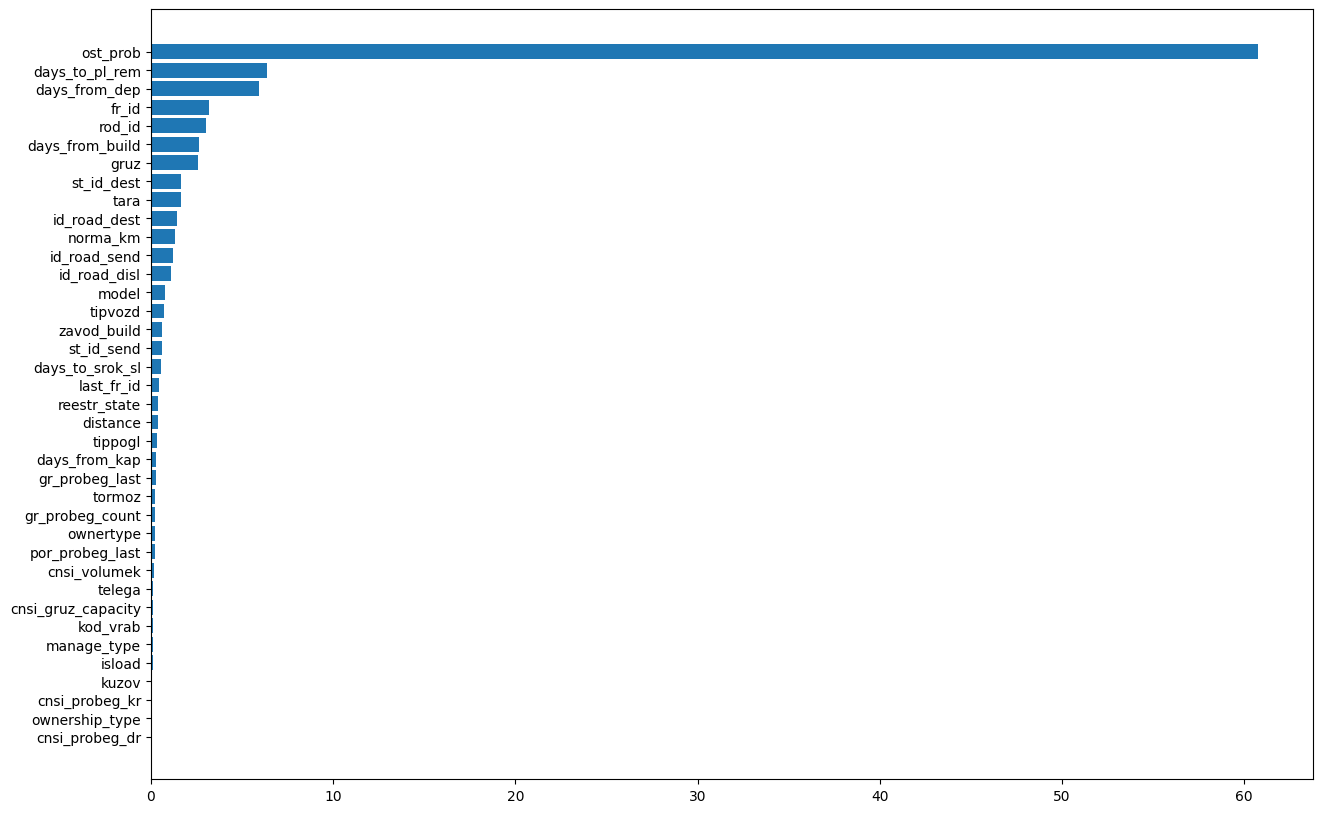

In [18]:
importance_month = pd.Series(models_month[0].feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(15, 10))
plt.barh(importance_month.index, importance_month)

<BarContainer object of 38 artists>

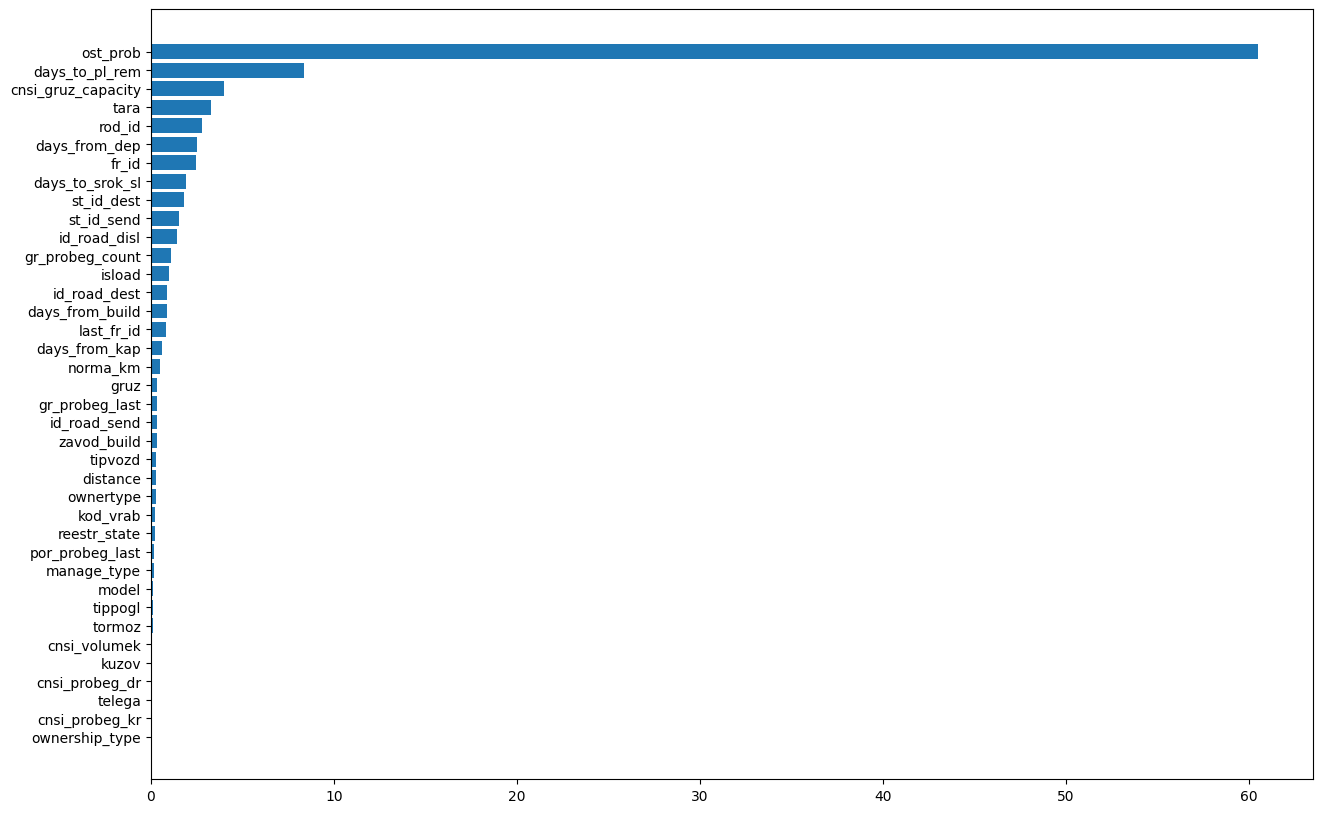

In [19]:
importance_month = pd.Series(models_day[0].feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(15, 10))
plt.barh(importance_month.index, importance_month)

In [20]:
df_test = preprocess([dislok, wag_prob, wag_param, freight_info, kti_izm, pr_rem, tr_rem, predict])

In [21]:
X_test = df_test.drop(["wagnum", "target_month", "target_day"], axis=1)

In [22]:
preds_month = np.zeros(X_test.shape[0])
preds_day = np.zeros(X_test.shape[0])

for model_m, model_d in zip(models_month, models_day):
    preds_month += model_m.predict(X_test) / len(models_month)
    preds_day += model_d.predict(X_test) / len(models_month)

In [23]:
predict["target_month"] = np.int32(preds_month >= 0.5)
predict["target_day"] = np.int32(preds_day >= 0.5)

In [24]:
predict.drop("m", axis=1).to_csv("catboost_night.csv", index=False)